In [1]:
'''
Windows: Open Anaconda prompt
conda create --name tigre_env -c anaconda -c ccpi -c conda-forge  python tigre simpleitk ipykernel opencv astropy tomopy nibabel scikit-image scikit-learn scipy tqdm scikit-learn-intelex jupyter ipywidgets
conda activate tigre_env

conda list --export > conda-package-list.txt
conda create -n tigre_env --file conda-package-list.txt
'''

import json
import math
import multiprocessing
import os
import sys
from __future__ import division


import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import tomopy
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from PIL import Image
from scipy import interpolate
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from skimage.registration import phase_cross_correlation
from tqdm import trange, tqdm
from typing import List
import SimpleITK as sitk


import tigre
import tigre.algorithms as algs
from tigre.utilities.geometry import Geometry

import shared_functions as s

kernel = Gaussian2DKernel(x_stddev=2)

drive = 'f:\\'

# base_folder = os.path.join(drive, 'jasper', 'data', '20220909_Legoman_nomotion') # Should be good
base_folder = os.path.join(drive, 'jasper', 'data', '20220929_Legoman_al_filter_110_um_variable_exposures') # Wrong
base_json_file = os.path.join(base_folder, 'scan_settings.json')
results_folder = os.path.join(base_folder, 'results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


# Make a list of globals for the reconstruction setting, and log them in a json file
gReconParams = dict()

gReconParams['pixels'] = 512  # (pixels)
gReconParams['pixel_pitch'] = 0.055  # (mm)
gReconParams['fill_gap'] = True
gReconParams['median_filter'] = False
gReconParams['bad_pixel_correction'] = True
gReconParams['recon_voxels'] = (
    gReconParams['pixels'], gReconParams['pixels'], gReconParams['pixels'])  # number of voxels (vx)
 
''' TODO These should really be read from the JSON file! '''
gReconParams['distance_source_detector'] = 188.347  # 9+9+30+100+30+9+1.347 (mm)
gReconParams['z_stage_distance_mm'] = s.get_sample_z_from_first_scan_json(base_json_file) # Varies between 0 and 100 mm
gReconParams['distance_object_detector'] = 30 + 3 + \
    gReconParams['z_stage_distance_mm'] + 9+1.347  # (mm)
gReconParams['detector_rotation'] = (math.radians(-0.3), 0., 0.)  # (mm)

assert gReconParams['z_stage_distance_mm'] < 100 and gReconParams['z_stage_distance_mm'] >= 0


DSD = gReconParams['distance_source_detector']
DSO = DSD - gReconParams['distance_object_detector']
# a = 2 * 512 * 0.055 / (((DSD-DSO) / DSO) + 1) #TODO have to explain the numbers
a = 512 * 0.055 / (((DSD-DSO) / DSO) + 1) #TODO have to explain the numbers ::: For 20220822_ffpe_whateverBreast
gReconParams['recon_size'] = (a, a, a)
# gReconParams['recon_size'] = (512*0.055,512*0.055,512*0.055)

print(gReconParams)

# 20220805_tumourWhateverBreast
# centre_of_rotation_offset_x_mm = -0.27  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = -0.24

# 20220822_ffpe_WhateverBreast
# centre_of_rotation_offset_x_mm = 0.16885  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = 0.0

# 20220727_HamnCheeseseries_M
centre_of_rotation_offset_x_mm = 0.43725  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
centre_of_rotation_offset_y_mm = 0

print(f'centre_of_rotation_offset_x_mm = {centre_of_rotation_offset_x_mm} (mm)')
print(f'centre_of_rotation_offset_y_mm = {centre_of_rotation_offset_y_mm} (mm)')

{'pixels': 512, 'pixel_pitch': 0.055, 'fill_gap': True, 'median_filter': False, 'bad_pixel_correction': True, 'recon_voxels': (512, 512, 512), 'distance_source_detector': 188.347, 'z_stage_distance_mm': 0.0, 'distance_object_detector': 43.347, 'detector_rotation': (-0.005235987755982988, 0.0, 0.0), 'recon_size': (21.679134788448977, 21.679134788448977, 21.679134788448977)}
centre_of_rotation_offset_x_mm = 0.43725 (mm)
centre_of_rotation_offset_y_mm = 0 (mm)


In [2]:
spectral_projs_th0, spectral_open_th0, spectral_projs_th1, spectral_open_th1, th0_list, th1_list, exp_time, angles, z_offset, detector_x_offsets, detector_y_offsets, th0_dacs_list, th1_dacs_list = \
    s.load_or_generate_data_arrays(base_json_file, base_folder, results_folder, gReconParams)

Loading existing numpy files, should take <7.5 seconds


100%|██████████| 7/7 [00:00<00:00, 101.36it/s]


In [3]:
''' Flip in both axes for the Legoman_al_filter_100_um_ datasets... 
Going from (2,3,0,1) to (0,1,2,3) '''

# spectral_projs_th0 = np.flip(np.flip(spectral_projs_th0, axis=2), axis=3)
# spectral_open_th0  = np.flip(np.flip(spectral_open_th0, axis=2), axis=3)
# spectral_projs_th1 = np.flip(np.flip(spectral_projs_th1, axis=2), axis=3)
# spectral_open_th1  = np.flip(np.flip(spectral_open_th1, axis=2), axis=3)

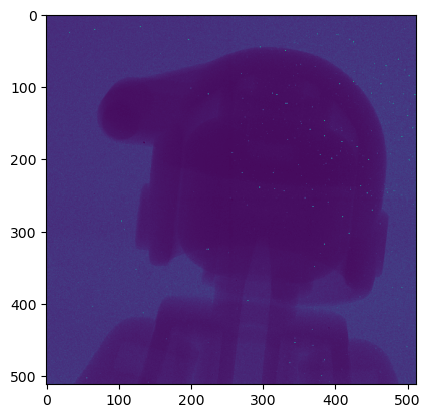

In [4]:
plt.imshow(spectral_projs_th0[0,0,:,:])
plt.show()

In [5]:
open_mean_th0 = np.mean(spectral_open_th0, axis=1)
open_mean_th1 = np.mean(spectral_open_th1, axis=1)

for i in range(open_mean_th0.shape[0]):
    print(i, open_mean_th0.shape, open_mean_th0.shape[0])  # E.g. 0 (9, 512, 512) 9
    open_mean_th0[i, :, :] /= exp_time[i]
    open_mean_th1[i, :, :] /= exp_time[i]

0 (7, 512, 512) 7
1 (7, 512, 512) 7
2 (7, 512, 512) 7
3 (7, 512, 512) 7
4 (7, 512, 512) 7
5 (7, 512, 512) 7
6 (7, 512, 512) 7


In [6]:
for i in range (open_mean_th0.shape[0]):
    print(th0_list[i], np.mean(open_mean_th0[i,:,:]))
    print(th1_list[i], np.mean(open_mean_th1[i,:,:]))

4.0 4849.093356874905
4.5 4560.191660736952
5.2 4117.314307732158
5.5 3919.4137126556598
6.0 3621.0400079625015
6.5 3367.2664422799994
7.0 3036.114307666647
7.5 2797.4329607729364
8.5 2264.463746917243
9.0 2042.5422023071387
10.5 1470.5482900355546
11.5 1256.1562785273422
12.5 1054.0376715520595
13.5 916.3632891819553


In [7]:
spectral_projs_low = spectral_projs_th0 #np.concatenate((spectral_projs_th0[0:5,:,:,:],spectral_projs_th1[0:5,:,:,:]), axis=0)
spectral_open_low = spectral_open_th0 # np.concatenate((spectral_open_th0[0:5,:,:,:],spectral_open_th1[0:5,:,:,:]), axis=0)
th_list_low = th0_list # np.concatenate((th0_list[0:5],th1_list[0:5]))
exp_time_low = exp_time # np.concatenate((exp_time[0:5],exp_time[0:5]))
th_dacs_list_low = th0_dacs_list #np.concatenate((th0_dacs_list[0:5,:],th1_dacs_list[0:5,:]),axis=0)

print(spectral_projs_low.shape, spectral_open_low.shape,th_dacs_list_low.shape )
print(th_list_low)
print(exp_time_low)

(7, 500, 512, 512) (7, 64, 512, 512) (7, 4)
[ 4.   5.2  6.   7.   8.5 10.5 12.5]
[ 2.24    2.56    2.944   3.3856  4.992  11.2    15.04  ]


In [8]:
spectral_projs_high = spectral_projs_th1 # np.concatenate((spectral_projs_th0[5:,:,:,:],spectral_projs_th1[5:,:,:,:]), axis=0)
spectral_open_high = spectral_open_th1 # np.concatenate((spectral_open_th0[5:,:,:,:],spectral_open_th1[5:,:,:,:]), axis=0)
th_list_high = th1_list # np.concatenate((th0_list[5:],th1_list[5:]))
exp_time_high = exp_time # np.concatenate((exp_time[5:],exp_time[5:]))
th_dacs_list_high = th1_dacs_list # np.concatenate((th0_dacs_list[5:,:],th1_dacs_list[5:,:]),axis=0)

print(spectral_projs_high.shape, spectral_open_high.shape,th_dacs_list_high.shape )
print(th_list_high)
print(exp_time_high)

(7, 500, 512, 512) (7, 64, 512, 512) (7, 4)
[ 4.5  5.5  6.5  7.5  9.  11.5 13.5]
[ 2.24    2.56    2.944   3.3856  4.992  11.2    15.04  ]


In [9]:
open_mean_low = np.mean(spectral_open_low, axis=1)

for i in range(open_mean_low.shape[0]):
    open_mean_low[i, :, :] /= exp_time_low[i]

for i in range(spectral_projs_low.shape[0]):
    spectral_projs_low[i, :, :, :] = spectral_projs_low[i, :, :, :] / exp_time_low[i]
    

In [10]:
open_mean_high = np.mean(spectral_open_high, axis=1)

for i in range(open_mean_high.shape[0]):
    open_mean_high[i, :, :] /= exp_time_high[i]

for i in range(spectral_projs_high.shape[0]):
    spectral_projs_high[i, :, :, :] = spectral_projs_high[i, :, :, :] / exp_time_high[i]
    

In [ ]:
polyorder_low = 2
regressions_0, residuals_0 = s.fit_proj_data_values(spectral_projs_low[:,:,0:256,0:256],   th_dacs_list_low[:, 0], polyorder=polyorder_low)
regressions_1, residuals_1 = s.fit_proj_data_values(spectral_projs_low[:,:,0:256,256:512], th_dacs_list_low[:, 1], polyorder=polyorder_low)
regressions_2, residuals_2 = s.fit_proj_data_values(spectral_projs_low[:,:,256:,256:],     th_dacs_list_low[:, 2], polyorder=polyorder_low)
regressions_3, residuals_3 = s.fit_proj_data_values(spectral_projs_low[:,:,256:512,0:256], th_dacs_list_low[:, 3], polyorder=polyorder_low)

proj_data_fits_low =np.zeros((polyorder_low+1,spectral_projs_low.shape[1], spectral_projs_low.shape[2], spectral_projs_low.shape[3]))

proj_data_fits_low[:,:,0:256,0:256] = regressions_0
proj_data_fits_low[:,:,0:256,256:512] = regressions_1
proj_data_fits_low[:,:,256:512,256:512] = regressions_2
proj_data_fits_low[:,:,256:512,0:256] = regressions_3

proj_data_fit_residuals =np.zeros((spectral_projs_low.shape[1], spectral_projs_low.shape[2], spectral_projs_low.shape[3]))
proj_data_fit_residuals[:,0:256,0:256] = residuals_0
proj_data_fit_residuals[:,0:256,256:512] = residuals_1
proj_data_fit_residuals[:,256:512,256:512] = residuals_2
proj_data_fit_residuals[:,256:512,0:256] = residuals_3

for i in range(0,proj_data_fits_low.shape[0]):
    sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits_low[i,:,:,:]), os.path.join(results_folder, 'regressions_low_'+str(i)+'.nii'))
sitk.WriteImage(sitk.GetImageFromArray(proj_data_fit_residuals), os.path.join(results_folder, 'regressions_low_residuals.nii'))

In [ ]:
# exponential fit is needed, can be obtained with a first order polynomial on log(x) data
polyorder_high = 1
regressions_0, residuals_0 = s.fit_proj_data_values(spectral_projs_high[:,:,0:256,0:256],   th_dacs_list_high[:, 0], polyorder=polyorder_high)
regressions_1, residuals_1 = s.fit_proj_data_values(spectral_projs_high[:,:,0:256,256:512], th_dacs_list_high[:, 1], polyorder=polyorder_high)
regressions_2, residuals_2 = s.fit_proj_data_values(spectral_projs_high[:,:,256:,256:],     th_dacs_list_high[:, 2], polyorder=polyorder_high)
regressions_3, residuals_3 = s.fit_proj_data_values(spectral_projs_high[:,:,256:512,0:256], th_dacs_list_high[:, 3], polyorder=polyorder_high)

proj_data_fits_high =np.zeros((polyorder_high+1,spectral_projs_high.shape[1], spectral_projs_high.shape[2], spectral_projs_high.shape[3]))

proj_data_fits_high[:,:,0:256,0:256] = regressions_0
proj_data_fits_high[:,:,0:256,256:512] = regressions_1
proj_data_fits_high[:,:,256:512,256:512] = regressions_2
proj_data_fits_high[:,:,256:512,0:256] = regressions_3

proj_data_fit_residuals =np.zeros((spectral_projs_high.shape[1], spectral_projs_high.shape[2], spectral_projs_high.shape[3]))
proj_data_fit_residuals[:,0:256,0:256] = residuals_0
proj_data_fit_residuals[:,0:256,256:512] = residuals_1
proj_data_fit_residuals[:,256:512,256:512] = residuals_2
proj_data_fit_residuals[:,256:512,0:256] = residuals_3

for i in range(0,proj_data_fits_high.shape[0]):
    sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits_high[i,:,:,:]), os.path.join(results_folder, 'regressions_high_'+str(i)+'.nii'))
sitk.WriteImage(sitk.GetImageFromArray(proj_data_fit_residuals), os.path.join(results_folder, 'regressions_high_residuals.nii'))

In [ ]:

print('Finding best DAC values per pixel...')
DAC_values = s.save_and_or_load_npy_files(
        results_folder, f'th_all_dac_values_low.npy', lambda: s.generate_correct_dac_values(gReconParams, open_mean_low, th_dacs_list_low, (0,1,2,3), False, polyorder_low))
print(len(th_dacs_list_low))
print(len(th_dacs_list_low[0]))
print(f'DAC_values.shape() = {DAC_values.shape}')
print(f'spectral_projs_low.shape() = {spectral_projs_low.shape}')
calc_dacs = np.repeat(DAC_values[np.newaxis, :, :], spectral_projs_low.shape[1], axis=0).flatten() # DAC_values e.g. --> (10,512,512)   spectral_projs_low e.g. --> (10,500,512,512)
print(f'calc_dacs.shape() = {calc_dacs.shape}')
    
for th in range(0, spectral_projs_low.shape[0]):
    a0 = 0
    a1 = (gReconParams['pixels'] // 2) - 1 # 255 for 512 pixels
    a2 = (gReconParams['pixels'] // 2) + 1 # 257 for 512 pixels
    a3 = gReconParams['pixels']
    mean = 0.25 * (
            np.mean(open_mean_low[th, a0:a1, a0:a1]) +
            np.mean(open_mean_low[th, a0:a1, a2:a3]) +
            np.mean(open_mean_low[th, a2:a3, a0:a1]) +
            np.mean(open_mean_low[th, a2:a3, a2:a3])
    )
    print(f'th = {th}, mean = {mean}')  # E.g. 36895.64768079413
    
    proj_data_fits_low_flat = proj_data_fits_low.reshape(proj_data_fits_low.shape[0], -1)
    proj_data_low_flat = (proj_data_fits_low_flat[0, :]*calc_dacs[th]**2) + (proj_data_fits_low_flat[1, :]*calc_dacs[th]**1) + proj_data_fits_low_flat[2, :] 
    

    projection_data = proj_data_low_flat.reshape(spectral_projs_low.shape[1], spectral_projs_low.shape[2], spectral_projs_low.shape[3])
    s.save_array(results_folder, 'Projections_' + str(th_list_low[th])+'_keV.npy', projection_data)
    
    ofc = -np.log(projection_data/mean)
    
    s.save_array(results_folder, 'Projections_'+str(th_list_low[th])+'OFC_interp.npy', ofc)

    ofc_bpc = s.save_and_or_load_npy_files(
            results_folder, f'th{th_list_low[th]}_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))
    if th == 0:
        stage_offset =  0.0
    else:
        stage_offset = centre_of_rotation_offset_x_mm 
    centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=20)
    print(th, centre_of_rotation_offset_x_mm)
    print('Doing recon finally!')
    plt.imshow(ofc_bpc[200,:,:])
    plt.show()
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    plt.imshow(img_th0[200,:,:])
    plt.show()
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_'+str(th_list_low[th])+'.nii', ni_img)

In [ ]:
for th in range(0, spectral_projs_high.shape[0]):
    a0 = 0
    a1 = (gReconParams['pixels'] // 2) - 1 # 255 for 512 pixels
    a2 = (gReconParams['pixels'] // 2) + 1 # 257 for 512 pixels
    a3 = gReconParams['pixels']
    mean = 0.25 * (
            np.mean(open_mean_high[th, a0:a1, a0:a1]) +
            np.mean(open_mean_high[th, a0:a1, a2:a3]) +
            np.mean(open_mean_high[th, a2:a3, a0:a1]) +
            np.mean(open_mean_high[th, a2:a3, a2:a3])
    )
    print(f'th = {th}, mean = {mean}')  # E.g. 36895.64768079413
    DAC_values = np.zeros((gReconParams['pixels'], gReconParams['pixels']))

    print('Finding best DAC values per pixel...')
    
    
    DAC_values = s.save_and_or_load_npy_files(
            results_folder, f'th{th}_dac_values_high.npy', lambda: s.generate_dac_values(gReconParams, open_mean_high, th_dacs_list_high, mean,th, False, polyorder=polyorder_high))
    calc_dacs = np.repeat(DAC_values[np.newaxis, :, :], spectral_projs_high.shape[1], axis=0).flatten()
    proj_data_fits_high_flat = proj_data_fits_high.reshape(proj_data_fits_high.shape[0], -1)
    if polyorder_high == 1:    
        proj_data_high_flat = np.exp(proj_data_fits_high_flat[1, :]) * np.exp(proj_data_fits_high_flat[0, :]*calc_dacs) 
    elif polyorder_high == 2:
        proj_data_high_flat = (proj_data_fits_high_flat[0, :]*calc_dacs**2) + (proj_data_fits_high_flat[1, :]*calc_dacs**1) + proj_data_fits_high_flat[2, :]     

    projection_data = proj_data_high_flat.reshape(spectral_projs_high.shape[1], spectral_projs_high.shape[2], spectral_projs_high.shape[3])
    

    
    # proj_data_flat.reshape(
    #     spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    s.save_array(results_folder, 'Projections_' + str(th_list_high[th])+'_keV.npy', projection_data)
    
    # TODO Ask Jasper about this VERY SUSPICIOUS CODE
    # mean = (np.mean(projection_data[:, :, 0:10]) + np.mean(projection_data[:, :, 503:513]))/2
    ofc = -np.log(projection_data/mean)
    
    s.save_array(results_folder, 'Projections_'+str(th_list_high[th])+'OFC_interp.npy', ofc)

    ofc_bpc = s.save_and_or_load_npy_files(
            results_folder, f'th{th_list_high[th]}_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))
    if th == 0:
        stage_offset =  0.0
    else:
        stage_offset = centre_of_rotation_offset_x_mm 
    centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=20)
    print(th, centre_of_rotation_offset_x_mm)
    print('Doing recon finally!')
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_'+str(th_list_high[th])+'.nii', ni_img)

In [ ]:
open_mean_th0 = np.mean(spectral_open_th0, axis=1)
open_mean_th1 = np.mean(spectral_open_th1, axis=1)
print(open_mean_th0.shape)
for i in range(0,spectral_projs_th0.shape[0]):
    ofc = -np.log(spectral_projs_th0[i,:,:,:]/open_mean_th0[i,:,:])
    ofc_bpc = s.save_and_or_load_npy_files(
                results_folder, f'th{i}test_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))
    if i== 0:
        stage_offset =  0.0
    else:
        stage_offset =centre_of_rotation_offset_x_mm
    centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=20)
    print(centre_of_rotation_offset_x_mm)
    gReconParams['detector_rotation'] = (math.radians(0.3), 0., 0.)  # (mm)
    img_th0, geo = s.recon_scan(gReconParams, ofc, angles, detector_x_offsets,
                            detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
        
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(i)+'fixedoffset.nii', ni_img)

In [ ]:
for i in range(0,spectral_projs_th1.shape[0]):
    ofc = -np.log(spectral_projs_th1[i,:,:,:]/open_mean_th0[i,:,:])
    ofc_bpc = s.save_and_or_load_npy_files(
                results_folder, f'th{i}test_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))
    if i== 0:
        stage_offset =  0.0
    else:
        stage_offset =centre_of_rotation_offset_x_mm
    centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=20)
    print(centre_of_rotation_offset_x_mm)
    gReconParams['detector_rotation'] = (math.radians(0.3), 0., 0.)  # (mm)
    img_th0, geo = s.recon_scan(gReconParams, ofc, angles, detector_x_offsets,
                            detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
        
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(i)+'.nii', ni_img)

In [ ]:
open_mean_th0 = np.mean(spectral_open_th0, axis=1)
open_mean_th1 = np.mean(spectral_open_th1, axis=1)

for i in range(open_mean_th0.shape[0]):
    print(i, open_mean_th0.shape, open_mean_th0.shape[0])  # E.g. 0 (9, 512, 512) 9
    open_mean_th0[i, :, :] /= exp_time[i]
    open_mean_th1[i, :, :] /= exp_time[i]

for i in range(spectral_projs_th0.shape[0]):
    spectral_projs_th0[i, :, :, :] = spectral_projs_th0[i, :, :, :] / exp_time[i]
    spectral_projs_th1[i, :, :, :] = spectral_projs_th1[i, :, :, :] / exp_time[i]

In [ ]:


for i in range (open_mean_th0.shape[0]):
    print(th0_list[i], np.mean(open_mean_th0[i,:,:]))
    # print(th1_list[i], np.mean(open_mean_th1[i,:,:]))
for i in range (open_mean_th0.shape[0]):
    # print(th0_list[i], np.mean(open_mean_th0[i,:,:]))
    print(th1_list[i], np.mean(open_mean_th1[i,:,:]))
    


In [ ]:
polyorder = 2
regressions_0, residuals_0 = s.fit_proj_data_values(spectral_projs_th0[:,:,256:,256:], th0_dacs_list[:, 0], polyorder=polyorder)
regressions_1, residuals_1 = s.fit_proj_data_values(spectral_projs_th0[:,:,256:512,0:256], th0_dacs_list[:, 1], polyorder=polyorder)
regressions_2, residuals_2 = s.fit_proj_data_values(spectral_projs_th0[:,:,0:256,0:256], th0_dacs_list[:, 2], polyorder=polyorder)
regressions_3, residuals_3 = s.fit_proj_data_values(spectral_projs_th0[:,:,0:256,256:512], th0_dacs_list[:, 3], polyorder=polyorder)

proj_data_fits =np.zeros((polyorder+1,spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))

proj_data_fits[:,:,256:512,256:512] = regressions_0
proj_data_fits[:,:,256:512,0:256] = regressions_1
proj_data_fits[:,:,0:256,0:256] = regressions_2
proj_data_fits[:,:,0:256,256:512] = regressions_3

proj_data_fit_residuals =np.zeros((spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))
proj_data_fit_residuals[:,256:512,256:512] = residuals_0
proj_data_fit_residuals[:,256:512,0:256] = residuals_1
proj_data_fit_residuals[:,0:256,0:256] = residuals_2
proj_data_fit_residuals[:,0:256,256:512] = residuals_3

for i in range(0,proj_data_fits.shape[0]):
    sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[i,:,:,:]), os.path.join(results_folder, 'regressions_'+str(i)+'.nii'))
sitk.WriteImage(sitk.GetImageFromArray(proj_data_fit_residuals), os.path.join(results_folder, 'regressions_residuals.nii'))

In [ ]:
# ni_img = nib.Nifti1Image(spectral_projs_th0[10,:,:,:], np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
# s.save_array(results_folder, 'Proj_th0_'+str(th0_list[10])+'proj_org.nii', ni_img)

for i in range (spectral_projs_th0.shape[0]):
    print(i, np.mean(spectral_projs_th0[i,:,:,:]))
    print(i, np.count_nonzero(spectral_projs_th0[i,:,:,:] == 0))

In [ ]:


for th in range(0, spectral_projs_th0.shape[0]):
    a0 = 0
    a1 = (gReconParams['pixels'] // 2) - 1 # 255 for 512 pixels
    a2 = (gReconParams['pixels'] // 2) + 1 # 257 for 512 pixels
    a3 = gReconParams['pixels']
    mean = 0.25 * (
            np.mean(open_mean_th0[th, a0:a1, a0:a1]) +
            np.mean(open_mean_th0[th, a0:a1, a2:a3]) +
            np.mean(open_mean_th0[th, a2:a3, a0:a1]) +
            np.mean(open_mean_th0[th, a2:a3, a2:a3])
    )
    print(f'th = {th}, mean = {mean}')  # E.g. 36895.64768079413
    DAC_values = np.zeros((gReconParams['pixels'], gReconParams['pixels']))

    print('Finding best DAC values per pixel...')
    
    
    DAC_values = s.save_and_or_load_npy_files(
            results_folder, f'th{th}_dac_values.npy', lambda: s.generate_dac_values(gReconParams, open_mean_th0, th0_dacs_list, mean,th, False, polyorder=polyorder))
    calc_dacs = np.repeat(DAC_values[np.newaxis, :, :], spectral_projs_th0.shape[1], axis=0).flatten()
    proj_data_fits_flat = proj_data_fits.reshape(proj_data_fits.shape[0], -1)
    if polyorder == 2:
        proj_data_flat = (proj_data_fits_flat[0, :]*calc_dacs**2) + (proj_data_fits_flat[1, :]*calc_dacs**1) + proj_data_fits_flat[2, :] 
    elif polyorder == 4:
        proj_data_flat = (proj_data_fits_flat[0, :]*calc_dacs**4) + (proj_data_fits_flat[1, :]*calc_dacs**3) + (proj_data_fits_flat[2, :]*calc_dacs**2) + (proj_data_fits_flat[3, :]*calc_dacs)+ proj_data_fits_flat[4, :]  


    projection_data = proj_data_flat.reshape(spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    

    
    # proj_data_flat.reshape(
    #     spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    s.save_array(results_folder, 'Projections_th0_' + str(th0_list[th])+'_keV.npy', projection_data)
    
    # TODO Ask Jasper about this VERY SUSPICIOUS CODE
    # mean = (np.mean(projection_data[:, :, 0:10]) + np.mean(projection_data[:, :, 503:513]))/2
    ofc = -np.log(projection_data/mean)
    print(ofc.shape)
    s.save_array(results_folder, 'projs_th0_'+str(th0_list[th])+'OFC_interp.npy', ofc)

    ofc_bpc = s.save_and_or_load_npy_files(
            results_folder, f'th{th}_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))
    if th == 0:
        stage_offset =  0.0
    else:
        stage_offset = centre_of_rotation_offset_x_mm 
    centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=80)
    print(th, centre_of_rotation_offset_x_mm)
    print('Doing recon finally!')
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC_3.nii', ni_img)
    
    # ofc =-np.log(spectral_projs_th0[th,:,:,:]/mean)
    # img_th0, geo = s.recon_scan(gReconParams, ofc, angles, detector_x_offsets,
    #                      detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    # ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    # s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_only.nii', ni_img)
    
    # ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 3)
    # img_th0, geo = s.recon_scan(gReconParams, ofc_bpc_mf, angles, detector_x_offsets,
    #                      detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    # ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    # s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC_MF3.nii', ni_img)

    # ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 5)
    # img_th0, geo = s.recon_scan(gReconParams, ofc_bpc_mf, angles, detector_x_offsets,
    #                      detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    # ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    # s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC_MF5.nii', ni_img)


In [ ]:
ofc_bpc = s.save_and_or_load_npy_files(
            results_folder, f'th{0}_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))

centre_of_rotation_offset_x_mm = 0.473
gReconParams['detector_rotation'] = (0., 0., 0.)  # (mm)
centre_of_rotation_offset_y_mm = 0
img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
                            detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
        
ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[0])+'.nii', ni_img)   
# for i in range(0,30, 10):
#     gReconParams['distance_object_detector'] = 30 + 0 + \
#         gReconParams['z_stage_distance_mm'] + 9+1.347  # (mm)
#     gReconParams['detector_rotation'] = (math.radians(i/100), 0., 0.)  # (mm)
#     img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
#                             detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
        
#     ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
#     s.save_array(results_folder, 'Recon_th0_'+str(th0_list[0])+'_'+ str(i/100)+'_.nii', ni_img)

In [ ]:
print(f'th = {th}, finding optimal offset')
global_detector_shift_y = .2 #find_optimal_offset(spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stageoffset=0, searchrange=25)
print(f'global_detector_shift_y = {global_detector_shift_y} (mm)')

ni_img = nib.Nifti1Image(ofc_bpc_mf, np.eye(4))
s.save_array(results_folder, 'Proj_th0_'+str(th0_list[th])+'OFC_BPC_MF.nii', ni_img)

print('Doing recon finally!')
img_th0 = s.recon_scan(gReconParams, ofc_bpc, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)

ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC.nii', ni_img)

img_th0 = s.recon_scan(gReconParams, ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)
ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC_MF.nii', ni_img)


In [ ]:
for th1 in range(0, open_mean_th1.shape[0]):
    mean = 0.25*(np.mean(open_mean_th1[th1, 0:255, 0:255]) + np.mean(open_mean_th1[th1, 0:255, 257:512]) + np.mean(
        open_mean_th1[th1, 257:512, 0:255]) + np.mean(open_mean_th1[th1, 257:512, 257:512]))
    print(mean)
    regression_out = np.zeros((3, 512, 512))
    DACvalues = np.zeros((512, 512))
    for i in range(0, open_mean_th1.shape[1]):
        for j in range(0, open_mean_th1.shape[2]):
            yvalues = open_mean_th1[:, i, j]
            regressions, res, _, _, _ = np.polyfit(th1_list, yvalues, 2, full=True)
            regression_out[:, i, j] = regressions
            DAC = s.solve_for_y(regressions, mean)[1]
            if (DAC > th1_list[th1]*2) or (DAC < th1_list[th1]/2):
                DAC = th1_list[th1]
            DACvalues[i, j] = DAC
    fitarray = spectral_projs_th1.reshape(spectral_projs_th1.shape[0], -1)
    regressions, res, _, _, _ = np.polyfit(th1_list, fitarray, 2, full=True)
    calcdacs = np.repeat(DACvalues[np.newaxis, :, :], spectral_projs_th1.shape[1], axis=0).flatten()

    projdataflat = (regressions[0, :]*calcdacs**2) + \
        (regressions[1, :]*calcdacs**1) + regressions[2, :]
    projectiondata = projdataflat.reshape(
        spectral_projs_th1.shape[1], spectral_projs_th1.shape[2], spectral_projs_th1.shape[3])
    np.save(os.path.join(results_folder, 'Projections_th1_'
            + str(th1_list[th1])+'_keV.npy'), projectiondata)

    mean = (np.mean(projectiondata[:, :, 0:10]) + np.mean(projectiondata[:, :, 503:513]))/2
    ofc = -np.log(projectiondata/mean)
    ni_img = nib.Nifti1Image(ofc, np.eye(4))
    np.save(os.path.join(results_folder, 'projs_th1_'+str(th1_list[th1])+'OFC_interp.npy'), ofc)
    ofc_mf = s.median_filter_projection_set(ofc, 5)
    diff_mf = np.abs(ofc-ofc_mf)
    meanmap = np.mean(diff_mf, axis=0)
    stdmap = np.std(diff_mf, axis=0)
    badmap = np.ones((512, 512))
    half = np.int32(badmap.shape[0]/2)
    badmap[half-2:half+1] = 0
    badmap[:, half-2:half+1] = 0
    badmap[meanmap > 0.2] = 0
    badmap[stdmap > 0.05] = 0
    ofc_bpc = s.apply_badmap_to_projections(ofc, badmap)
    ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 3)
    img_th1 = s.recon_scan(ofc_bpc, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    ni_img = nib.Nifti1Image(img_th1, np.eye(4))
    nib.save(ni_img, os.path.join(results_folder, 'Recon_th1_'+str(th1_list[th1])+'OFC_BPC.nii'))
    img_th1 = s.recon_scan(ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    ni_img = nib.Nifti1Image(img_th1, np.eye(4))
    nib.save(ni_img, os.path.join(results_folder, 'Recon_th1_'+str(th1_list[th1])+'OFC_BPC_MF.nii'))


In [ ]:

openmeansingle_th0 = np.mean(open_mean_th0, axis=(1, 2))
openmeansingle_th1 = np.mean(open_mean_th1, axis=(1, 2))
plt.scatter(th0_list, openmeansingle_th0, label="th0")
plt.scatter(th1_list, openmeansingle_th1, label="th1")


In [ ]:
# global_detector_shift_y = 0.37565
global_detector_shift_y = -0.31872500000000004

hyperlist = [500]
lambdalist = [0.010]
for hyper in hyperlist:
    for tvlambda in lambdalist:
        # hyper=2.0e3
        tviter = 100
        # tvlambda=0.005
        img_th0 = s.recon_scan_fista(ofc_2_mf.astype(np.float32), angles, z_offset, detector_x_offsets,
                                   detector_y_offsets, global_detector_shift_y, hyper, tviter, tvlambda)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(base_folder, 'recon_fista_mf_'
                 + str(tviter) + '_' + str(hyper)+'_'+str(tvlambda) + '.nii'))


In [ ]:
drive = 'f:\\'
# basefolder = os.path.join(drive,'jasper','data','20220726_scanseries')
base_folder = os.path.join(drive, 'jasper', 'data', '20220805_tumourWhateverBreast')
base_json_file = os.path.join(base_folder, 'scan_settings.json')
results_folder = os.path.join(base_folder, 'results_open_after')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
if os.path.exists(base_json_file):
    f = open(base_json_file)
    dashboard = json.load(f)
    spectral_projs_th0 = []
    spectral_open_th0 = []
    spectral_projs_th1 = []
    spectral_open_th1 = []
    th0_list = []
    exp_time = []
    th1_list = []
    th1_exp_time = []
    for i in dashboard['thresholdscan']:
        scan_folder = os.path.join(base_folder, dashboard['thresholdscan'][i]['projectionsfolder'])
        scan_json = os.path.join(scan_folder, dashboard['thresholdscan'][i]['projections_json'])
        open_image_folder = os.path.join(
            base_folder, dashboard['thresholdscan'][i]['openimagesfolder'])
        open_image_json = os.path.join(
            open_image_folder, dashboard['thresholdscan'][i]['openimages_json'])
        folder_string = dashboard['thresholdscan'][i]['projectionsfolder']
        th0_keV = folder_string[0:folder_string.find('_')]
        th1_keV = folder_string[folder_string.find('_')+1:]
        exp_time.append(s.get_exposure_time_projection(scan_json))
        th0_list.append(float(th0_keV))
        th1_list.append(float(th1_keV))

        projs_th0 = s.projectionsloader(
            scan_json, th0=True, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        openimg_th0 = s.openimgloader(
            open_image_json, th0=True, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        projs_th1 = s.projectionsloader(
            scan_json, th0=False, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        openimg_th1 = s.openimgloader(
            open_image_json, th0=False, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        spectral_projs_th0.append(projs_th0)
        spectral_open_th0.append(openimg_th0)
        spectral_projs_th1.append(projs_th1)
        spectral_open_th1.append(openimg_th1)
        detector_x_offsets, detector_y_offsets = s.get_detector_offsets(scan_json)
        angles = s.get_proj_angles(scan_json)
        z_offset = s.get_samplestage_z_offset(scan_json)
    spectral_projs_th0 = np.asarray(spectral_projs_th0)
    spectral_open_th0 = np.asarray(spectral_open_th0)
    spectral_projs_th1 = np.asarray(spectral_projs_th1)
    spectral_open_th1 = np.asarray(spectral_open_th1)
    exp_time = np.asarray(exp_time)
    th0_list = np.asarray(th0_list)
    th1_list = np.asarray(th1_list)

    np.save(os.path.join(results_folder, 'projs_stack_th0.npy'), spectral_projs_th0)
    np.save(os.path.join(results_folder, 'open_stack_th0.npy'), spectral_open_th0)
    np.save(os.path.join(results_folder, 'projs_stack_th1.npy'), spectral_projs_th1)
    np.save(os.path.join(results_folder, 'open_stack_th1.npy'), spectral_open_th1)
    np.save(os.path.join(results_folder, 'thlist_th0.npy'), th0_list)
    np.save(os.path.join(results_folder, 'thlist_th1.npy'), th1_list)

    # print(spectralprojs.shape, spectralopen.shape)
    # out = np.load(os.path.join(basefolder,'Projections_fitted.npy'))
    # openout = np.load(os.path.join(basefolder,'Projections_open_fitted.npy'))


In [ ]:
drive = 'f:\\'
basefolder = os.path.join(drive, 'jasper', 'data', '20220603_RealTumor')
basejsonfile = os.path.join(basefolder, 'scan_settings.json')

if os.path.exists(basejsonfile):
    f = open(basejsonfile)
    dashboard = json.load(f)
    for i in dashboard['thresholdscan']:
        scanfolder = os.path.join(basefolder, dashboard['thresholdscan'][i]['projectionsfolder'])
        scanjson = os.path.join(scanfolder, dashboard['thresholdscan'][i]['projections_json'])
        detector_x_offsets, detector_y_offsets = s.get_detector_offsets(scanjson)
        angles = s.get_proj_angles(scanjson)
        z_offset = s.get_samplestage_z_offset(scanjson)
        projs_th0 = s.get_OFC_projections(scanjson, th0=True, UseOrig=False, ApplyLog=True)

        # projectionsCorr = tomopy.prep.stripe.remove_all_stripe(projs_th0, snr=3, la_size=61, sm_size=21, dim=1, ncore=60, nchunk=None)
        projectionsCorr = tomopy.prep.stripe.remove_stripe_fw(
            projs_th0, level=None, wname='db5', sigma=0.2, pad=True, ncore=60, nchunk=None)
        # global_detector_shift_y = find_optimal_offset(projs_th0, angles, detector_x_offsets, detector_y_offsets, z_offset)
        global_detector_shift_y = 0.1915
        gReconVoxels = (600, 512, 512)             # number of voxels              (vx)
        gReconSize = (15, 12.8, 12.8)          # total size of the image       (mm)

        img_th0 = s.recon_scan(projs_th0, angles, z_offset, detector_x_offsets,
                             detector_y_offsets, global_detector_shift_y)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(basefolder, 'recon_'+str(0)+'_th0_orig.nii'))
        # imgfdk = tomopy.misc.corr.remove_ring(img_th0, center_x=None, center_y=None, thresh=1000.0, thresh_max=5000.0, thresh_min=10.0, theta_min=50, rwidth=10, int_mode='WRAP', ncore=60, nchunk=None, out=None)
        # ni_img = nib.Nifti1Image(imgfdk, np.eye(4))
        # nib.save(ni_img,  os.path.join(basefolder,'recon_'+str(0)+'_th0_corr_pre_post.nii'))
        img_th0 = s.recon_scan(projectionsCorr, angles, z_offset, detector_x_offsets,
                             detector_y_offsets, global_detector_shift_y)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(basefolder, 'recon_'+str(0)+'_th0_corr2.nii'))
